# Import Libraries

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard
import pyttsx3

# Keypoints using MP Holistic

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
def draw_landmarks(image, results):
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(120,120,120), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(1,1,1), thickness=2, circle_radius=2)) 

In [5]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [6]:
draw_landmarks(frame, results)

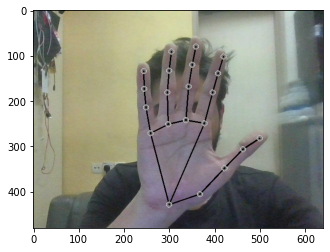

In [7]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# Extract Keypoint Values

In [8]:
len(results.right_hand_landmarks.landmark)

21

In [9]:
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

In [10]:
def extract_keypoints(results):
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([rh])

In [11]:
result_test = extract_keypoints(results)

In [12]:
result_test

array([ 4.69997644e-01,  8.92556489e-01,  6.25612074e-07,  5.75858831e-01,
        8.44915867e-01, -3.40577662e-02,  6.60544574e-01,  7.26106644e-01,
       -4.51531932e-02,  7.24072158e-01,  6.37745678e-01, -5.67069687e-02,
        7.82063723e-01,  5.89258492e-01, -6.93097338e-02,  5.91911435e-01,
        5.20271420e-01, -1.80013198e-02,  6.19165123e-01,  3.78906518e-01,
       -4.42854688e-02,  6.38702929e-01,  2.90036470e-01, -6.91151097e-02,
        6.56987727e-01,  2.14501530e-01, -8.81697387e-02,  5.27384996e-01,
        5.05817115e-01, -2.47492250e-02,  5.37355721e-01,  3.51347685e-01,
       -4.75860834e-02,  5.49762666e-01,  2.50581264e-01, -7.20392838e-02,
        5.62204361e-01,  1.67370707e-01, -9.12831947e-02,  4.66473490e-01,
        5.23671210e-01, -3.78444716e-02,  4.63906646e-01,  3.77320409e-01,
       -6.23071268e-02,  4.69571054e-01,  2.77918190e-01, -8.44545588e-02,
        4.77910161e-01,  1.91330701e-01, -1.00892082e-01,  4.06031489e-01,
        5.65367162e-01, -

# Setup Folders for Collection

In [13]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('Dataset') 

# Actions that we try to detect
actions = np.array(['zero', 'one', 'two', 'three', 'four', 'five'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

# Folder start
start_folder = 0

In [ ]:
for action in actions: 
    for sequence in range(start_folder, start_folder+no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

# Collect Keypoint Values for Training and Testing

In [ ]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(start_folder, start_folder+no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
cap.release()
cv2.destroyAllWindows()

# Preprocess Data and Create Labels and Features

In [15]:
label_map = {label:num for num, label in enumerate(actions)}

In [16]:
label_map

{'zero': 0, 'one': 1, 'two': 2, 'three': 3, 'four': 4, 'five': 5}

In [17]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [18]:
np.array(sequences).shape

(534, 30, 63)

In [19]:
np.array(labels).shape

(534,)

In [20]:
X = np.array(sequences)

In [21]:
X.shape

(534, 30, 63)

In [22]:
y = to_categorical(labels).astype(int)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [24]:
y_train.shape

(507, 6)

In [25]:
y_test.shape

(27, 6)

# LSTM RNN Model using Tensorflow

In [27]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [28]:
model = Sequential()
model.add(LSTM(32, return_sequences=True, activation='relu', input_shape=(30,63)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [29]:
res = [.7, 0.2, 0.1]

In [30]:
actions[np.argmax(res)]

'zero'

In [31]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

Training

In [32]:
# model.fit(X_train, y_train, epochs=500, callbacks=[tb_callback])

Epoch 1/500
 9/16 [===============>..............] - ETA: 0s - loss: 1.7902 - categorical_accuracy: 0.1551

KeyboardInterrupt: 

In [83]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 32)            12288     
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 128)           82432     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 198       
Total params: 150,566
Trainable params: 150,566
Non-trainable params: 0
__________________________________________________

# Make Predictions

In [34]:
res = model.predict(X_test)

In [35]:
actions[np.argmax(res[4])]

'five'

In [36]:
actions[np.argmax(y_test[4])]

'five'

# Save Weights

In [ ]:
# model.save('actionDetection.h5')

In [ ]:
# del model

In [33]:
model.load_weights('actionDetection.h5')

# Evaluation using Confusion Matrix and Accuracy

In [38]:
yhat = model.predict(X_test)

In [39]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [40]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[20,  1],
        [ 0,  6]],

       [[23,  0],
        [ 1,  3]],

       [[21,  0],
        [ 0,  6]],

       [[23,  0],
        [ 0,  4]],

       [[23,  0],
        [ 0,  4]],

       [[24,  0],
        [ 0,  3]]], dtype=int64)

In [41]:
accuracy_score(ytrue, yhat)

0.9629629629629629

# Test in Real Time

In [43]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [91]:
engine = pyttsx3.init()
voices = engine.getProperty('voices')
engine.setProperty('voice', voices[1].id)
volume = engine.getProperty('volume')
engine.setProperty('volume',1.0)
rate = engine.getProperty('rate')
engine.setProperty('rate', 125) 


# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.7

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 10: 
                sentence = sentence[-10:]
            
        cv2.rectangle(image, (0,0), (640, 40), (0, 0, 0), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Authintication
        password = ['five', 'three', 'one', 'zero']
        access_status = np.array_equal(password,sentence)
        if len(sentence) == 4:
            if access_status:
                cv2.rectangle(image, (0,40), (640, 80), (50, 50, 50), -1)
                cv2.putText(image, 'Access Granted', (3,70), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
                engine.say("Access Granted")
                engine.runAndWait()
                engine.stop()
                break
            elif access_status == 0:
                cv2.rectangle(image, (0,40), (640, 80), (50, 50, 50), -1)
                cv2.putText(image, 'Access Denied', (3,70), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
                engine.say("Access Denied, please try again")
                engine.runAndWait()
                engine.stop()
                sentence.clear()
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
zero
<class 'mediapipe.python.solution_base.SolutionOutputs'>
zero
<class 'mediapipe.python.solution_base.SolutionOutputs'>
zero
<class 'mediapipe.python.solution_base.SolutionOutputs'>
zero
<class 'mediapipe.python.solution_base.SolutionOutputs'>
zero
<class 'mediapipe.python.solution_base.SolutionOutputs'>
zero
<class 'mediapipe.python.solution_base.SolutionOutputs'>
zero
<class 'mediapipe.python.solution_base.SolutionOutputs'>
zero
<class 'mediapipe.python.solution_base.SolutionOutputs'>
zero
<class 'mediapipe.python.solution_base.SolutionOutputs'>
zero
<class 'mediapipe.python.solution_base.SolutionOutputs'>
zero
<class 'mediapipe.python.solution_base.SolutionOutputs'>
zero
<class 'mediapipe.python.solution_base.SolutionOutputs'>
zero
<class 'mediapipe.python.solution_base.SolutionOutputs'>
zero
<class 'mediapipe.python.solution_base.SolutionOutputs'>
zero
<class 'mediapipe.python.solution_base.SolutionOutputs'>
zero
<class '

In [90]:
cap.release()
cv2.destroyAllWindows()